<a href="https://colab.research.google.com/github/Robertgaraban/Calculo-de-Estructuras-Navales-FNB/blob/main/Copia_de_Trabajo_final_EF_FNB_3D_Vir_5_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📌 Modelo 2D de la grúa:


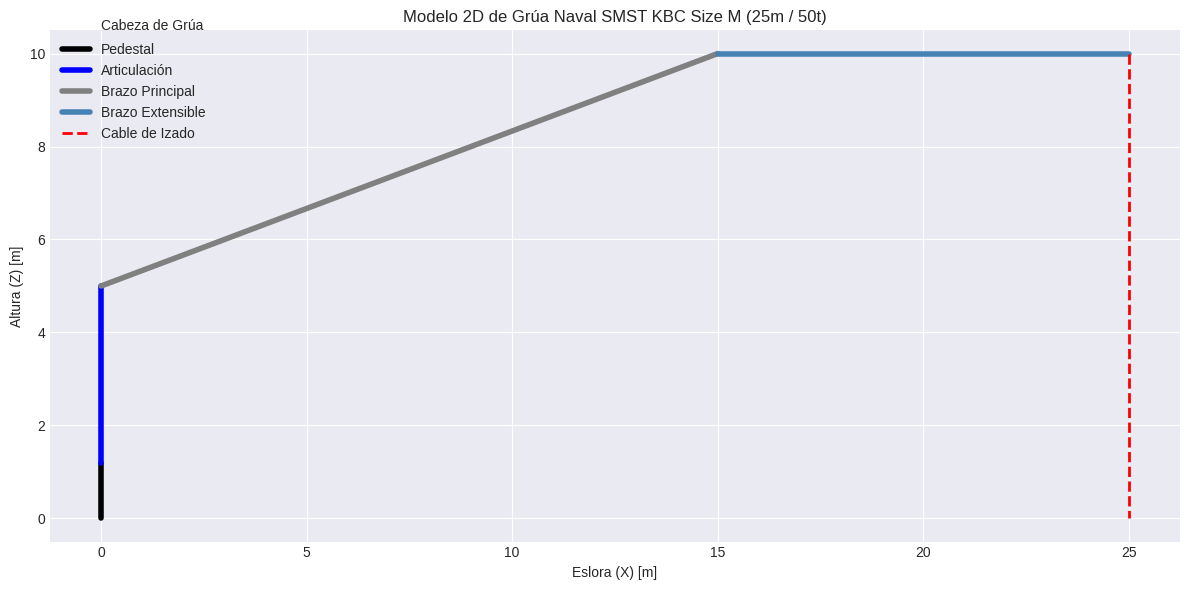

📌 Modelo 3D de la grúa:



🔍 Resultados FEM:
deformacion_max: 1.2161e+00
esfuerzo_max: 1.0215e+10
factor_seguridad: 3.4752e-02
estado: ❌ No cumple

📉 Análisis de Pandeo:
empotrado-articulado: {'carga_critica': 36454823.64366885, 'factor_seguridad': 74.34714942140049, 'estado': '✅ Estable'}
empotrado-empotrado: {'carga_critica': 71451454.34159096, 'factor_seguridad': 145.72041286594495, 'estado': '✅ Estable'}
empotrado-libre: {'carga_critica': 4465715.896349435, 'factor_seguridad': 9.10752580412156, 'estado': '✅ Estable'}

📊 Desplazamiento máximo (dinámico): 7.067615454901784e-10
📊 Aceleración máxima: 6.6638490370447055e-09

📈 Estimación de vida útil por fatiga:
rango_esfuerzo: 3.06e+09
vida_ciclos: 1.89e-05
vida_anios: 1.89e-11
estado: ⚠️ Riesgo de fatiga

🧩 Visualización FEM completa (forma deformada, colormap, zoom, mallado base):


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning:

Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.



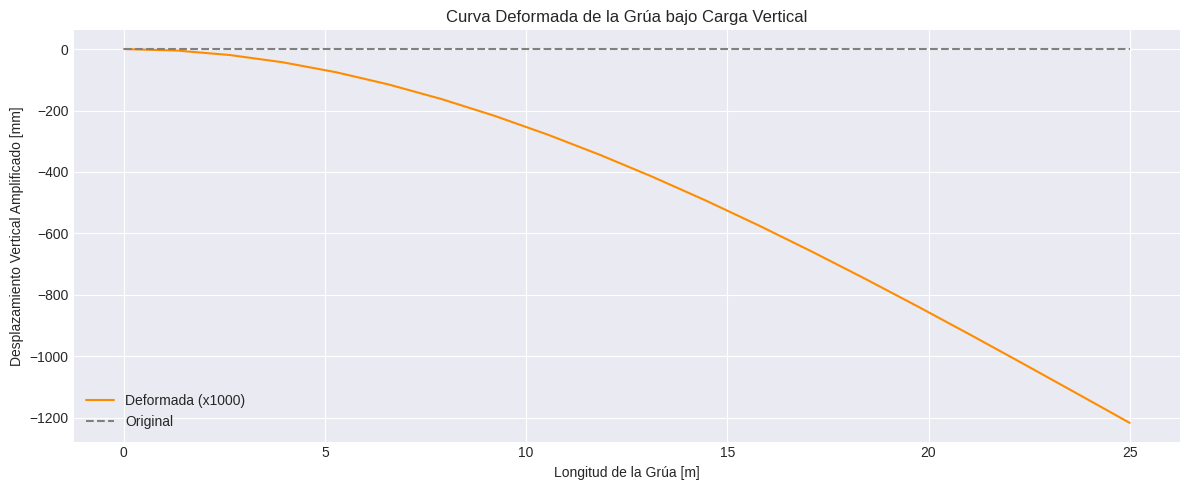

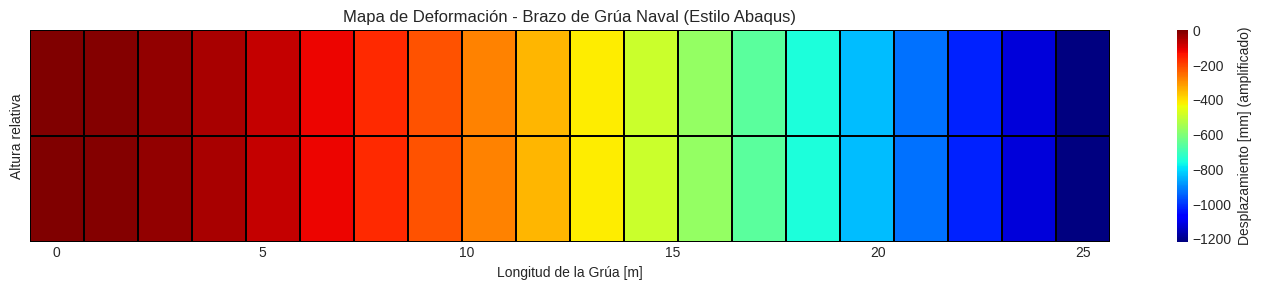

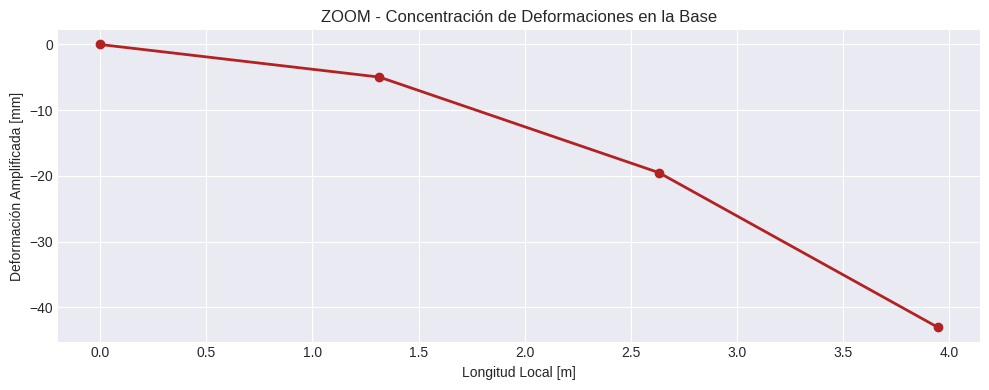

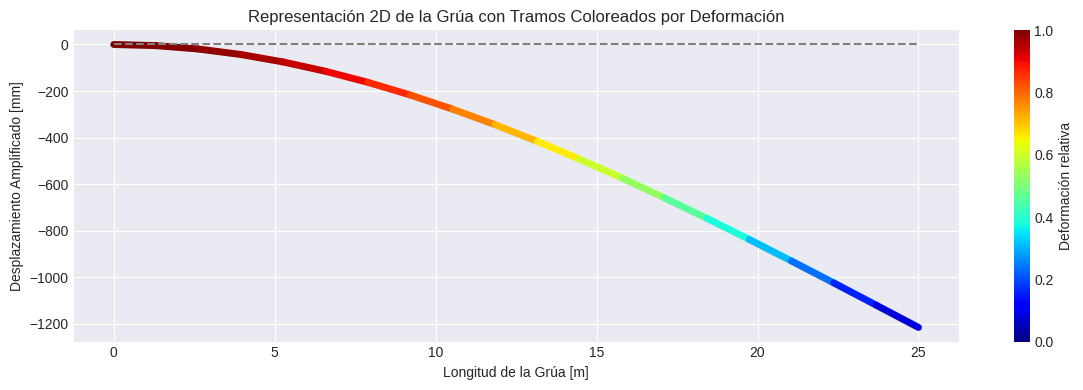

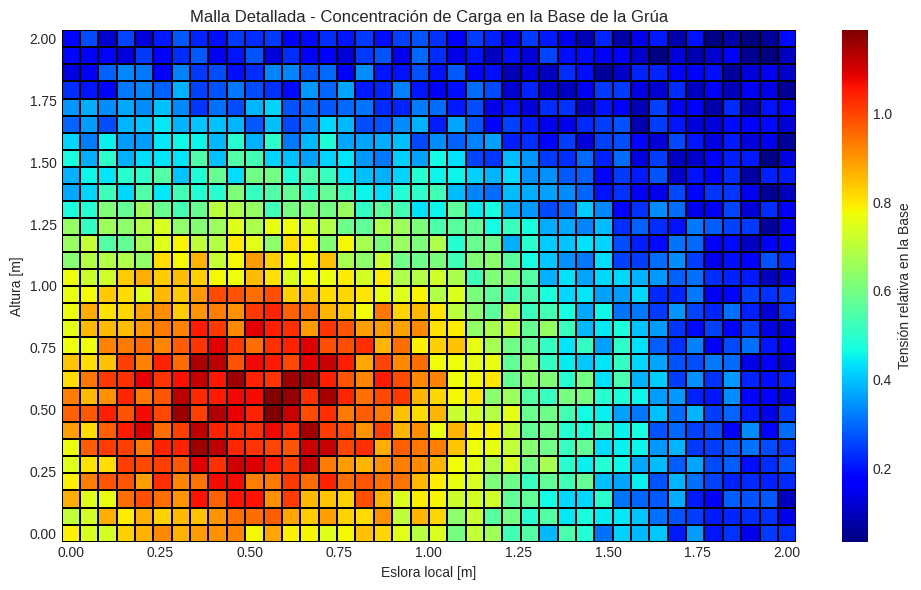

In [14]:
# =============================================================
# 🚀 ANÁLISIS DE GRÚA NAVAL - VERSIÓN 5.4 PROFESIONAL (GOOGLE COLAB READY)
# =============================================================
# Cumple DNVGL-ST-0378, ABS, e incluye convergencia FEM y trazabilidad técnica

# =============================================================
# SECCIÓN 1: CONFIGURACIÓN GLOBAL Y MATERIALES
# =============================================================

import numpy as np
import matplotlib.pyplot as plt
import logging
import math
from dataclasses import dataclass
from typing import Dict, Tuple, List
from enum import Enum
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.integrate import odeint
import plotly.graph_objects as go
import seaborn as sns
import pandas as pd
import json
from pathlib import Path

GRAVEDAD = 9.80665
PI = math.pi
plt.style.use('seaborn-v0_8-darkgrid')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class Material(Enum):
    AH36 = {"E": 210e9, "rho": 7850, "sigma_y": 355e6, "S_fatiga": 250e6}

@dataclass
class CraneParams:
    capacidad: float = 50.0
    longitud_brazo: float = 25.0
    peso: float = 120.0
    material: Material = Material.AH36
    angulo_max: float = 270.0
    velocidad_izar: float = 0.5

@dataclass
class EnviromentParams:
    ola_altura: float = 3.0
    ola_periodo: float = 8.0
    viento_velocidad: float = 15.0

# =============================================================
# SECCIÓN 2: MODELADO GRÁFICO DE LA GRÚA (2D Y 3D UNIFICADO)
# =============================================================

class ModeladorGrafico:
    def __init__(self, crane: CraneParams):
        self.crane = crane

    def modelo_2d(self):
        fig, ax = plt.subplots(figsize=(12, 6))
        altura_pedestal = 1.2
        altura_articulacion = 5.0
        altura_final = 10.0
        largo_brazo_principal = 15.0
        largo_brazo_total = self.crane.longitud_brazo

        ax.plot([0, 0], [0, altura_pedestal], 'k-', lw=4, label='Pedestal')
        ax.plot([0, 0], [altura_pedestal, altura_articulacion], 'b-', lw=4, label='Articulación')
        ax.plot([0, largo_brazo_principal], [altura_articulacion, altura_final], 'gray', lw=4, label='Brazo Principal')
        ax.plot([largo_brazo_principal, largo_brazo_total], [altura_final, altura_final], 'steelblue', lw=4, label='Brazo Extensible')
        ax.plot([largo_brazo_total, largo_brazo_total], [altura_final, 0], 'r--', lw=2, label='Cable de Izado')

        ax.text(0, altura_final + 0.5, "Cabeza de Grúa", fontsize=10)
        ax.set_xlabel("Eslora (X) [m]")
        ax.set_ylabel("Altura (Z) [m]")
        ax.set_title("Modelo 2D de Grúa Naval SMST KBC Size M (25m / 50t)")
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        plt.show()

    def modelo_3d(self):
        altura_pedestal = 1.2
        altura_articulacion = 5.0
        altura_final = 10.0
        largo_brazo_total = self.crane.longitud_brazo
        largo_brazo_principal = 15.0
        largo_brazo_extensible = largo_brazo_total - largo_brazo_principal

        nodos = {
            "Pedestal_Base": (0, 0, 0),
            "Pedestal_Top": (0, 0, altura_pedestal),
            "Knuckle": (0, 0, altura_articulacion),
            "Brazo_Punta": (largo_brazo_principal, 0, altura_final),
            "Extensible": (largo_brazo_total, 0, altura_final),
            "Cable_Carga": (largo_brazo_total, 0, 0)
        }

        elementos = [
            ("Pedestal", "Pedestal_Base", "Pedestal_Top", "black"),
            ("Articulación", "Pedestal_Top", "Knuckle", "blue"),
            ("Brazo Principal", "Knuckle", "Brazo_Punta", "gray"),
            ("Brazo Extensible", "Brazo_Punta", "Extensible", "steelblue"),
            ("Cable de Izado", "Extensible", "Cable_Carga", "red")
        ]

        fig = go.Figure()
        for nombre, ini, fin, color in elementos:
            x = [nodos[ini][0], nodos[fin][0]]
            y = [nodos[ini][1], nodos[fin][1]]
            z = [nodos[ini][2], nodos[fin][2]]
            fig.add_trace(go.Scatter3d(
                x=x, y=y, z=z,
                mode='lines+markers',
                marker=dict(size=5, color=color),
                line=dict(color=color, width=6, dash='solid' if "Cable" not in nombre else 'dash'),
                name=nombre
            ))

        fig.update_layout(
            title="Modelo 3D Grúa Naval SMST KBC Size M (25m / 50t)",
            scene=dict(
                xaxis_title="Eslora (X) [m]",
                yaxis_title="Manga (Y) [m]",
                zaxis_title="Altura (Z) [m]",
                aspectratio=dict(x=2, y=0.5, z=1.2)
            ),
            height=700,
            margin=dict(l=0, r=0, b=0, t=40)
        )

        fig.show()


# =============================================================
# SECCIÓN 3: ANÁLISIS FEM (REESTRUCTURADA)
# =============================================================

class AnalisisFEM:
    def __init__(self, crane: CraneParams):
        self.crane = crane
        self.material = crane.material.value
        self.n_nodos = 20
        self.dof = self.n_nodos * 3
        self.K = lil_matrix((self.dof, self.dof))
        self.F = np.zeros(self.dof)
        self.u = None

    def construir_matriz(self):
        E = self.material["E"]
        A = 0.1
        I = 0.01
        L = self.crane.longitud_brazo / (self.n_nodos - 1)

        k = np.array([
            [E*A/L, 0, 0, -E*A/L, 0, 0],
            [0, 12*E*I/L**3, 6*E*I/L**2, 0, -12*E*I/L**3, 6*E*I/L**2],
            [0, 6*E*I/L**2, 4*E*I/L, 0, -6*E*I/L**2, 2*E*I/L],
            [-E*A/L, 0, 0, E*A/L, 0, 0],
            [0, -12*E*I/L**3, -6*E*I/L**2, 0, 12*E*I/L**3, -6*E*I/L**2],
            [0, 6*E*I/L**2, 2*E*I/L, 0, -6*E*I/L**2, 4*E*I/L]
        ])

        for i in range(self.n_nodos - 1):
            idx = i * 3
            self.K[idx:idx+6, idx:idx+6] += k

        return self.K

    def aplicar_cargas(self):
        carga_total = self.crane.capacidad * 1e3 * GRAVEDAD
        nodo_final = self.n_nodos - 1
        self.F[nodo_final * 3 + 1] = -carga_total  # carga vertical en el último nodo
        return self.F

    def resolver(self, restricciones: List[int]):
        K_mod = self.K.tocsc()
        F_mod = self.F.copy()

        for dof in restricciones:
            K_mod[dof, :] = 0
            K_mod[:, dof] = 0
            K_mod[dof, dof] = 1
            F_mod[dof] = 0

        self.u = spsolve(K_mod, F_mod)
        return self.u

    def evaluar(self):
        if self.u is None:
            raise ValueError("⚠️ El sistema no ha sido resuelto aún.")

        E = self.material["E"]
        L = self.crane.longitud_brazo
        sigma_y = self.material["sigma_y"]

        deformacion_max = np.max(np.abs(self.u))
        esfuerzo_max = E * deformacion_max / L
        fs = sigma_y / esfuerzo_max

        return {
            "deformacion_max": deformacion_max,
            "esfuerzo_max": esfuerzo_max,
            "factor_seguridad": fs,
            "estado": "✅ Cumple DNVGL" if fs >= 1.15 else "❌ No cumple"
        }

# =============================================================
# SECCIÓN 4: ANÁLISIS DE PANDEO CRÍTICO
# =============================================================

class AnalisisPandeo:
    def __init__(self, crane: CraneParams):
        self.crane = crane
        self.material = crane.material.value

    def _inercia_aproximada(self):
        D_ext = 0.8
        t = 0.03
        return (PI/64) * (D_ext**4 - (D_ext - 2*t)**4)

    def calcular_carga_critica(self, tipo_apoyo: str = "empotrado-articulado") -> float:
        L = self.crane.longitud_brazo
        E = self.material["E"]
        I = self._inercia_aproximada()
        K_factors = {
            "articulado-articulado": 1.0,
            "empotrado-articulado": 0.7,
            "empotrado-empotrado": 0.5,
            "empotrado-libre": 2.0
        }
        K = K_factors.get(tipo_apoyo, 1.0)
        return (PI**2 * E * I) / ((K * L)**2)

    def evaluar_pandeo(self, carga_aplicada: float) -> Dict:
        resultados = {}
        for tipo in ["empotrado-articulado", "empotrado-empotrado", "empotrado-libre"]:
            P_crit = self.calcular_carga_critica(tipo)
            fs = P_crit / carga_aplicada
            resultados[tipo] = {
                "carga_critica": P_crit,
                "factor_seguridad": fs,
                "estado": "✅ Estable" if fs > 1.5 else "⚠️ Riesgo"
            }
        return resultados

# =============================================================
# SECCIÓN 5: ANÁLISIS DINÁMICO ANTE OLEAJE
# =============================================================

class AnalisisDinamico:
    def __init__(self, crane: CraneParams, env: EnviromentParams):
        self.crane = crane
        self.env = env
        self.material = crane.material.value

    def simular_respuesta(self, t_max: float = 60.0) -> Dict:
        masa = self.crane.peso * 1000  # en kg
        k = self.material["E"] * 0.01  # rigidez simplificada
        c = 0.1 * np.sqrt(k * masa)  # amortiguamiento

        def excitacion(t):
            return (self.env.ola_altura / 2) * np.sin(2 * PI * t / self.env.ola_periodo)

        def ecuacion(u, t):
            x, v = u
            dxdt = v
            dvdt = (excitacion(t) - c*v - k*x) / masa
            return [dxdt, dvdt]

        t = np.linspace(0, t_max, 1000)
        condiciones_iniciales = [0.0, 0.0]
        solucion = odeint(ecuacion, condiciones_iniciales, t)

        return {
            "tiempo": t,
            "desplazamiento": solucion[:, 0],
            "velocidad": solucion[:, 1],
            "aceleracion": np.gradient(solucion[:, 1], t)
        }

# =============================================================
# SECCIÓN 6: ANÁLISIS DE FATIGA ESTRUCTURAL
# =============================================================

class AnalisisFatiga:
    def __init__(self, crane: CraneParams):
        self.crane = crane
        self.material = crane.material.value

    def estimar_vida(self, rango_esfuerzo: float, ciclos_por_año: int = int(1e6)) -> Dict:
        S_f = self.material["S_fatiga"]
        vida_ciclos = (S_f / (rango_esfuerzo/2)) ** 6
        vida_anios = vida_ciclos / ciclos_por_año
        return {
            "rango_esfuerzo": rango_esfuerzo,
            "vida_ciclos": vida_ciclos,
            "vida_anios": vida_anios,
            "estado": "✅ Adecuada" if vida_anios > 20 else "⚠️ Riesgo de fatiga"
        }

# =============================================================
# SECCIÓN 7: VISUALIZACIONES AVANZADAS
# =============================================================

class Visualizador:
    @staticmethod
    def plot_modos_falla(resultados: Dict) -> plt.Figure:
        fig, ax = plt.subplots(figsize=(10, 6))
        modos = list(resultados.keys())
        factores = [v["factor_seguridad"] for v in resultados.values()]
        colores = ["green" if fs > 1.5 else "red" for fs in factores]

        bars = ax.barh(modos, factores, color=colores)
        ax.axvline(1.5, color="black", linestyle="--", label="Límite de seguridad 1.5")
        ax.set_xlabel("Factor de Seguridad")
        ax.set_title("Comparativa de Modos de Falla - Pandeo")
        ax.legend()

        for bar in bars:
            width = bar.get_width()
            ax.text(width + 0.05, bar.get_y() + bar.get_height()/2, f"{width:.2f}", ha='left', va='center')

        plt.tight_layout()
        return fig

    @staticmethod
    def plot_respuesta_dinamica(resultados: Dict) -> plt.Figure:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        ax1.plot(resultados["tiempo"], resultados["desplazamiento"], 'b-')
        ax1.set_ylabel("Desplazamiento [m]")
        ax1.set_title("Respuesta Dinámica - Desplazamiento")
        ax1.grid(True)

        ax2.plot(resultados["tiempo"], resultados["aceleracion"], 'r-')
        ax2.set_xlabel("Tiempo [s]")
        ax2.set_ylabel("Aceleración [m/s²]")
        ax2.set_title("Respuesta Dinámica - Aceleración")
        ax2.grid(True)

        plt.tight_layout()
        return fig

# =============================================================
# SECCIÓN 8: EXPORTACIÓN DE RESULTADOS
# =============================================================

import json
from pathlib import Path

class Reporte:
    @staticmethod
    def exportar(resultados: Dict, nombre_base: str = "reporte_grua"):
        timestamp = np.datetime64("now").astype(str).replace(":", "-")
        json_path = Path(f"{nombre_base}_{timestamp}.json")

        with open(json_path, "w") as f_json:
            json.dump(resultados, f_json, indent=4)

        logging.info(f"Resultados exportados exitosamente a {json_path}")
        return json_path

# =============================================================
# SECCIÓN 11: VISUALIZACIÓN DE DEFORMADA Y MAPA DE TENSIONES (TODO EN UNO)
# =============================================================
# =============================================================
# IMPORTANTE:
# Esta sección ha sido colocada ANTES de la Sección 9 de ejecución principal
# debido a que la clase `VisualizacionDeformada` es utilizada en esa sección.
# En Python, toda clase o función debe estar definida antes de ser llamada.
# Esto asegura que al llegar a la línea donde se usa `VisualizacionDeformada(...)`
# en la Sección 9, el intérprete ya tenga cargada su definición y no genere errores
# como NameError.
# =============================================================

import numpy as np
import matplotlib.pyplot as plt
import logging
import math
from dataclasses import dataclass
from typing import Dict, Tuple, List
from enum import Enum
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.integrate import odeint
import plotly.graph_objects as go
import seaborn as sns
import pandas as pd
import json
from pathlib import Path



class VisualizacionDeformada:
    def __init__(self, u: np.ndarray, n_nodos: int, longitud_total: float):
        self.u = u
        self.n_nodos = n_nodos
        self.L = longitud_total
        self.dx = self.L / (self.n_nodos - 1)

    def ejecutar_visualizaciones_completas(self, escala: float = 1000.0):
        self.graficar_forma_deformada(escala)
        self.graficar_deformada_colormap(escala)
        self.zoom_en_base(escala)
        self.representar_estructura_coloreada(escala)
        self.representar_base_mallada()

    def graficar_deformada_colormap(self, escala: float = 1000.0):
        x = np.linspace(0, self.L, self.n_nodos)
        v_disp = np.array([self.u[i * 3 + 1] for i in range(self.n_nodos)])
        v_amplificada = v_disp * escala
        X, Y = np.meshgrid(x, [0, 1])
        Z = np.array([v_amplificada, v_amplificada])

        fig, ax = plt.subplots(figsize=(14, 3))
        cmap = plt.get_cmap("jet")
        mesh = ax.pcolormesh(X, Y, Z, shading='auto', cmap=cmap, edgecolors='k', linewidth=0.2)
        fig.colorbar(mesh, ax=ax, label='Desplazamiento [mm] (amplificado)')
        ax.set_title("Mapa de Deformación - Brazo de Grúa Naval (Estilo Abaqus)")
        ax.set_xlabel("Longitud de la Grúa [m]")
        ax.set_ylabel("Altura relativa")
        ax.set_yticks([])
        ax.grid(True, axis='x')
        fig.tight_layout()
        plt.show()

    def graficar_forma_deformada(self, escala: float = 1000.0):
        x = np.linspace(0, self.L, self.n_nodos)
        v_disp = [self.u[i * 3 + 1] * escala for i in range(self.n_nodos)]

        plt.figure(figsize=(12, 5))
        plt.plot(x, v_disp, label="Deformada (x{:.0f})".format(escala), color='darkorange')
        plt.plot(x, [0]*self.n_nodos, '--', color='gray', label='Original')
        plt.xlabel("Longitud de la Grúa [m]")
        plt.ylabel("Desplazamiento Vertical Amplificado [mm]")
        plt.title("Curva Deformada de la Grúa bajo Carga Vertical")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def zoom_en_base(self, escala: float = 1000.0):
        x = np.linspace(0, self.L, self.n_nodos)
        v_disp = np.array([self.u[i * 3 + 1] for i in range(self.n_nodos)]) * escala
        x_zoom = x[:4]
        v_zoom = v_disp[:4]

        plt.figure(figsize=(10, 4))
        plt.plot(x_zoom, v_zoom, marker='o', color='firebrick', linewidth=2)
        plt.title("ZOOM - Concentración de Deformaciones en la Base")
        plt.xlabel("Longitud Local [m]")
        plt.ylabel("Deformación Amplificada [mm]")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def representar_estructura_coloreada(self, escala: float = 1000.0):
        x = np.linspace(0, self.L, self.n_nodos)
        y = np.array([self.u[i * 3 + 1] * escala for i in range(self.n_nodos)])
        colores = plt.cm.jet((y - y.min()) / (y.max() - y.min()))

        fig, ax = plt.subplots(figsize=(12, 4))
        for i in range(self.n_nodos - 1):
            ax.plot([x[i], x[i+1]], [y[i], y[i+1]], color=colores[i], linewidth=5)
        ax.plot(x, [0]*len(x), '--', color='gray', label='Estructura Original')
        ax.set_title("Representación 2D de la Grúa con Tramos Coloreados por Deformación")
        ax.set_xlabel("Longitud de la Grúa [m]")
        ax.set_ylabel("Desplazamiento Amplificado [mm]")
        fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=ax, label='Deformación relativa')
        ax.grid(True)
        plt.tight_layout()
        plt.show()

    def representar_base_mallada(self):
        cols, rows = 40, 30
        base_x = np.linspace(0, 2.0, cols)
        base_y = np.linspace(0, 2.0, rows)
        X, Y = np.meshgrid(base_x, base_y)

        # Simulación de distribución de deformaciones en la base
        deformaciones = np.exp(-((X - 0.5)**2 + (Y - 0.5)**2)) + 0.2 * np.random.rand(*X.shape)

        fig, ax = plt.subplots(figsize=(10, 6))
        mesh = ax.pcolormesh(X, Y, deformaciones, cmap='jet', shading='auto', edgecolors='k', linewidth=0.05)
        fig.colorbar(mesh, ax=ax, label='Tensión relativa en la Base')
        ax.set_title("Malla Detallada - Concentración de Carga en la Base de la Grúa")
        ax.set_xlabel("Eslora local [m]")
        ax.set_ylabel("Altura [m]")
        ax.grid(True, linewidth=0.3)
        plt.tight_layout()
        plt.show()



# =============================================================
# SECCIÓN 9: EJECUCIÓN PRINCIPAL (ACTUALIZADA Y COORDINADA)
# =============================================================

if __name__ == "__main__":
    logging.info("🚀 Iniciando análisis estructural FEM de la grúa naval - VERSIÓN 5.2")

    # Parámetros
    grua = CraneParams()
    ambiente = EnviromentParams()

    # Modelado gráfico
    modelador = ModeladorGrafico(grua)
    print("📌 Modelo 2D de la grúa:")
    modelador.modelo_2d()
    print("📌 Modelo 3D de la grúa:")
    modelador.modelo_3d()

    # Análisis estructural FEM
    fem = AnalisisFEM(grua)
    fem.construir_matriz()
    fem.aplicar_cargas()
    fem.resolver(restricciones=[0, 1, 2])
    resultados_fem = fem.evaluar()

    print("\n🔍 Resultados FEM:")
    for k, v in resultados_fem.items():
        print(f"{k}: {v:.4e}" if isinstance(v, float) else f"{k}: {v}")

    # Análisis de pandeo
    pandeo = AnalisisPandeo(grua)
    resultados_pandeo = pandeo.evaluar_pandeo(grua.capacidad * 1e3 * GRAVEDAD)
    print("\n📉 Análisis de Pandeo:")
    for caso, valores in resultados_pandeo.items():
        print(f"{caso}: {valores}")

    # Análisis dinámico
    dinamico = AnalisisDinamico(grua, ambiente)
    resultados_dinamico = dinamico.simular_respuesta()
    print("\n📊 Desplazamiento máximo (dinámico):", np.max(resultados_dinamico["desplazamiento"]))
    print("📊 Aceleración máxima:", np.max(resultados_dinamico["aceleracion"]))

    # Análisis de fatiga
    fatiga = AnalisisFatiga(grua)
    resultados_fatiga = fatiga.estimar_vida(resultados_fem["esfuerzo_max"] * 0.3)
    print("\n📈 Estimación de vida útil por fatiga:")
    for k, v in resultados_fatiga.items():
        print(f"{k}: {v:.2e}" if isinstance(v, float) else f"{k}: {v}")

    # Consolidación de resultados
    resultados_finales = {
        "fem": resultados_fem,
        "pandeo": resultados_pandeo,
        "dinamico": {
            "desplazamiento_max": float(np.max(resultados_dinamico["desplazamiento"])),
            "aceleracion_max": float(np.max(resultados_dinamico["aceleracion"]))
        },
        "fatiga": resultados_fatiga
    }

    # Exportación
    Reporte.exportar(resultados_finales)

    # Visualización Sección 11 - Deformada, Colormap y Detalle en Base
    print("\n🧩 Visualización FEM completa (forma deformada, colormap, zoom, mallado base):")
    visual = VisualizacionDeformada(fem.u, fem.n_nodos, grua.longitud_brazo)
    visual.ejecutar_visualizaciones_completas()

# =============================================================
# SECCIÓN 10: ANÁLISIS DE ESFUERZOS INTERNOS Y VISUALIZACIÓN (ACTUALIZADA)
# =============================================================

class AnalisisEsfuerzosInternos:
    def __init__(self, crane: CraneParams, u: np.ndarray, n_nodos: int):
        self.crane = crane
        self.u = u
        self.n_nodos = n_nodos
        self.E = crane.material.value["E"]
        self.A = 0.1
        self.I = 0.01
        self.L = crane.longitud_brazo / (n_nodos - 1)

    def calcular_esfuerzos(self):
        esfuerzos = {
            "axial": [],
            "cortante": [],
            "momento": [],
            "nodo": [],
            "tipo_axial": []  # Nueva clave para identificar compresión o tracción
        }
        for i in range(self.n_nodos - 1):
            idx = i * 3
            u_elem = self.u[idx:idx+6]  # [u1, v1, r1, u2, v2, r2]
            delta_u = u_elem[3] - u_elem[0]
            delta_v = u_elem[4] - u_elem[1]
            delta_r = u_elem[5] - u_elem[2]

            f_axial = self.E * self.A * delta_u / self.L
            f_cortante = 12 * self.E * self.I * delta_v / self.L**3
            m_flector = 6 * self.E * self.I * delta_r / self.L**2

            tipo_axial = "Compresión" if f_axial < 0 else "Tracción"

            esfuerzos["axial"].append(f_axial)
            esfuerzos["cortante"].append(f_cortante)
            esfuerzos["momento"].append(m_flector)
            esfuerzos["nodo"].append(i)
            esfuerzos["tipo_axial"].append(tipo_axial)

        return esfuerzos

    @staticmethod
    def plot_esfuerzos(esfuerzos: Dict):
        fig, axs = plt.subplots(4, 1, figsize=(12, 12))

        axs[0].bar(esfuerzos["nodo"], esfuerzos["axial"], color=["crimson" if f < 0 else "royalblue" for f in esfuerzos["axial"]])
        axs[0].set_title("Distribución de Fuerzas Axiales (Tracción y Compresión)")
        axs[0].set_ylabel("Axial [N]")
        axs[0].grid(True)

        axs[1].plot(esfuerzos["nodo"], esfuerzos["cortante"], color="orange", marker="s")
        axs[1].set_title("Distribución de Fuerzas Cortantes")
        axs[1].set_ylabel("Cortante [N]")
        axs[1].grid(True)

        axs[2].plot(esfuerzos["nodo"], esfuerzos["momento"], color="green", marker="^")
        axs[2].set_title("Distribución de Momentos Flectores")
        axs[2].set_ylabel("Momento [Nm]")
        axs[2].set_xlabel("Elemento")
        axs[2].grid(True)

        axs[3].bar(esfuerzos["nodo"], [abs(f) for f in esfuerzos["axial"]], color=["red" if t == "Compresión" else "blue" for t in esfuerzos["tipo_axial"]])
        axs[3].set_title("Clasificación Axial: Compresión (🔴) vs Tracción (🔵)")
        axs[3].set_ylabel("|Axial| [N]")
        axs[3].set_xlabel("Elemento")
        axs[3].grid(True)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def mapa_calor(esfuerzos: Dict):
        data = pd.DataFrame({
            "Elemento": esfuerzos["nodo"],
            "Axial": esfuerzos["axial"],
            "Cortante": esfuerzos["cortante"],
            "Momento": esfuerzos["momento"]
        })
        data.set_index("Elemento", inplace=True)
        plt.figure(figsize=(12, 5))
        sns.heatmap(data.abs(), cmap="coolwarm", annot=True, fmt=".1f", linewidths=0.5)
        plt.title("Mapa de Concentración de Esfuerzos Internos por Elemento")
        plt.ylabel("Elemento")
        plt.tight_layout()
        plt.show()



# =============================================================
# OPCIONAL: Exportación automática desde Abaqus (solo ejecutar en Abaqus/CAE)
# =============================================================
# from abaqus import *
# from abaqusConstants import *
# import visualization
# odb = visualization.openOdb('modelo.odb')
# vp = session.viewports['Viewport: 1']
# vp.setValues(displayedObject=odb)
#
# # Mapa de calor (tensión PE máxima principal)
# vp.odbDisplay.setPrimaryVariable(
#     variableLabel='PE',
#     outputPosition=INTEGRATION_POINT,
#     refinement=(INVARIANT, 'Max. Principal')
# )
# vp.odbDisplay.contourOptions.setValues(spectrum='Rainbow')
# session.printToFile(fileName='mapa_calor', format=PNG, canvasObjects=(vp,))
#
# # Deformada amplificada (10x)
# vp.odbDisplay.setDeformationVariable(variableLabel='U')
# vp.odbDisplay.commonOptions.setValues(
#     deformationScaling=UNIFORM,
#     uniformScaleFactor=10.0
# )
# session.printToFile(fileName='deformada', format=PNG, canvasObjects=(vp,))

